# Music Genre Classification using Machine Learning

 Use machine learning to train a model to classify audio tracks into genres. According to their “research” a machine learning model should be able to label the tracks into genres more accurately. 

In [1]:
# import visualisation libraries
import os
import sys

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import Ridge

# import python scripts we created to help with feature engineering
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.helpers import identify_highly_correlated_features, identify_low_variance_features, identify_missing_data, feature_importance_plot
from src.learning_curve_plot import learning_curve_plot

  

# Read and Explore the Data

In [2]:
songs_data = pd.read_csv("../data/songs_data.csv")
songs_data

,track_id,track_name,track_artist,track_popularity,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6ho0GyrWZN3mhi9zVRW7xi,Losing It,FISHER,79,edm,0.760,0.964,2,-5.844,1,0.0576,0.001820,0.700000,0.0974,0.6410,125.000,248036
1,4bYJKHG6KLdGzHQRJMaFc8,Rock And Roll All Nite,KISS,3,rock,0.581,0.831,1,-8.045,1,0.1070,0.045800,0.000000,0.0782,0.8850,144.684,168160
2,1VGlMYqPO1LHyclvfIMvWI,Snälla bli min (Hjalm Remix),Robin Lukovic,0,edm,0.661,0.760,8,-4.769,1,0.0268,0.000406,0.040700,0.6110,0.4390,99.993,271238
3,6BbINUfGabVyiNFJpQXn3x,Wicked,Future,62,rap,0.718,0.679,11,-5.899,0,0.0706,0.001910,0.010400,0.3850,0.2050,157.970,173347
4,1Ly0ssAgeM7YqdHptao8Oe,Paranoid,Black Sabbath,15,rock,0.426,0.619,4,-11.501,0,0.0722,0.000084,0.002390,0.1700,0.3820,162.721,168440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28391,639L1OUV4JRqnPHaQaziYO,Black Water,Massface,35,rock,0.253,0.931,11,-3.093,1,0.0616,0.000595,0.002170,0.0978,0.3320,194.911,208077
28392,4bQGI1roeSr8Q85on2tQNU,Lean On Me,Club Nouveau,2,r&b,0.748,0.629,0,-8.420,1,0.0660,0.016800,0.000000,0.0991,0.9190,182.448,294947
28393,32gaGfRgDMrMtcpCqF078U,Morning Dew,Matt Quentin,58,pop,0.686,0.332,9,-11.759,1,0.0454,0.890000,0.342000,0.1070,0.0745,80.994,237037
28394,7At7pljkrkgjwy0utWu2xx,eoh (Theis EZ Remix),Hallasen,33,edm,0.845,0.505,10,-5.481,1,0.0516,0.057500,0.000424,0.0335,0.2050,125.037,143095


In [3]:
# shape of the data
songs_data.shape

(28396, 17)

In [4]:
songs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28396 entries, 0 to 28395
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          28396 non-null  object 
 1   track_name        28392 non-null  object 
 2   track_artist      28392 non-null  object 
 3   track_popularity  28396 non-null  int64  
 4   genre             28396 non-null  object 
 5   danceability      28396 non-null  float64
 6   energy            28396 non-null  float64
 7   key               28396 non-null  int64  
 8   loudness          28396 non-null  float64
 9   mode              28396 non-null  int64  
 10  speechiness       28396 non-null  float64
 11  acousticness      28396 non-null  float64
 12  instrumentalness  28396 non-null  float64
 13  liveness          28396 non-null  float64
 14  valence           28396 non-null  float64
 15  tempo             28396 non-null  float64
 16  duration_ms       28396 non-null  int64 

In [5]:
# identify missing data
songs_data.isnull().sum()

track_id            0
track_name          4
track_artist        4
track_popularity    0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
dtype: int64

In [6]:
#Showing the rows that are missing data at "track_artist" column
songs_data[songs_data.track_artist.isnull()]

,track_id,track_name,track_artist,track_popularity,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
16265,5TTzhRSWQS4Yu8xTgAuq6D,NaN,NaN,0,rap,0.465,0.820,10,-5.907,0,0.3070,0.0963,0.00000,0.0888,0.505,86.839,206465
16995,5cjecvX0CmC9gK0Laf5EMQ,NaN,NaN,0,rap,0.678,0.659,11,-5.364,0,0.3190,0.0534,0.00000,0.5530,0.191,146.153,202235
25483,69gRFGOWY9OMpFJgFol1u0,NaN,NaN,0,rap,0.714,0.821,6,-7.635,1,0.1760,0.0410,0.00000,0.1160,0.649,95.999,282707
27825,3VKFip3OdAvv4OfNTgFWeQ,NaN,NaN,0,latin,0.675,0.919,11,-6.075,0,0.0366,0.0606,0.00653,0.1030,0.726,97.017,252773


In [7]:
#Showing the rows that are missing data at "track_name" column
songs_data[songs_data.track_name.isnull()]

,track_id,track_name,track_artist,track_popularity,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
16265,5TTzhRSWQS4Yu8xTgAuq6D,NaN,NaN,0,rap,0.465,0.820,10,-5.907,0,0.3070,0.0963,0.00000,0.0888,0.505,86.839,206465
16995,5cjecvX0CmC9gK0Laf5EMQ,NaN,NaN,0,rap,0.678,0.659,11,-5.364,0,0.3190,0.0534,0.00000,0.5530,0.191,146.153,202235
25483,69gRFGOWY9OMpFJgFol1u0,NaN,NaN,0,rap,0.714,0.821,6,-7.635,1,0.1760,0.0410,0.00000,0.1160,0.649,95.999,282707
27825,3VKFip3OdAvv4OfNTgFWeQ,NaN,NaN,0,latin,0.675,0.919,11,-6.075,0,0.0366,0.0606,0.00653,0.1030,0.726,97.017,252773


In [8]:
# summary statistics for all the data

songs_data.describe()


,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,28396.000000,28396.000000,28396.000000,28396.000000,28396.000000,28396.000000,28396.000000,28396.000000,28396.000000,28396.000000,28396.000000,28396.000000,28396.000000
mean,39.336104,0.653386,0.698387,5.368256,-6.817541,0.565397,0.107990,0.177263,0.091143,0.190986,0.510434,120.955390,226575.367094
std,23.706486,0.145799,0.183484,3.613898,3.036443,0.495714,0.102623,0.222908,0.232566,0.156015,0.234309,26.957635,61076.581384
min,0.000000,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,21.000000,0.561000,0.579000,2.000000,-8.309000,0.000000,0.041000,0.014400,0.000000,0.092600,0.329000,99.972000,187766.500000
50%,42.000000,0.670000,0.722000,6.000000,-6.262000,1.000000,0.062700,0.079700,0.000021,0.127000,0.512000,121.993000,216921.000000
75%,58.000000,0.760000,0.843000,9.000000,-4.708750,1.000000,0.133000,0.260000,0.006573,0.249000,0.695000,133.999500,254965.500000
max,100.000000,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


In [9]:
# drop any features that have a low std

low_var_features = identify_low_variance_features(songs_data, std_threshold=0.1)
songs_data.drop(low_var_features, axis = 1, inplace = True)

number of low variance features: 0
low variance features: []


C:\Users\ericy\IP302- Project Exam\src\helpers.py:15: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_df = pd.DataFrame(df.std()).rename(columns = {0: 'standard_deviation'})


C:\Users\ericy\AppData\Local\Temp\ipykernel_16232\1761531130.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(songs_data.corr(),annot=True,linewidth =2)


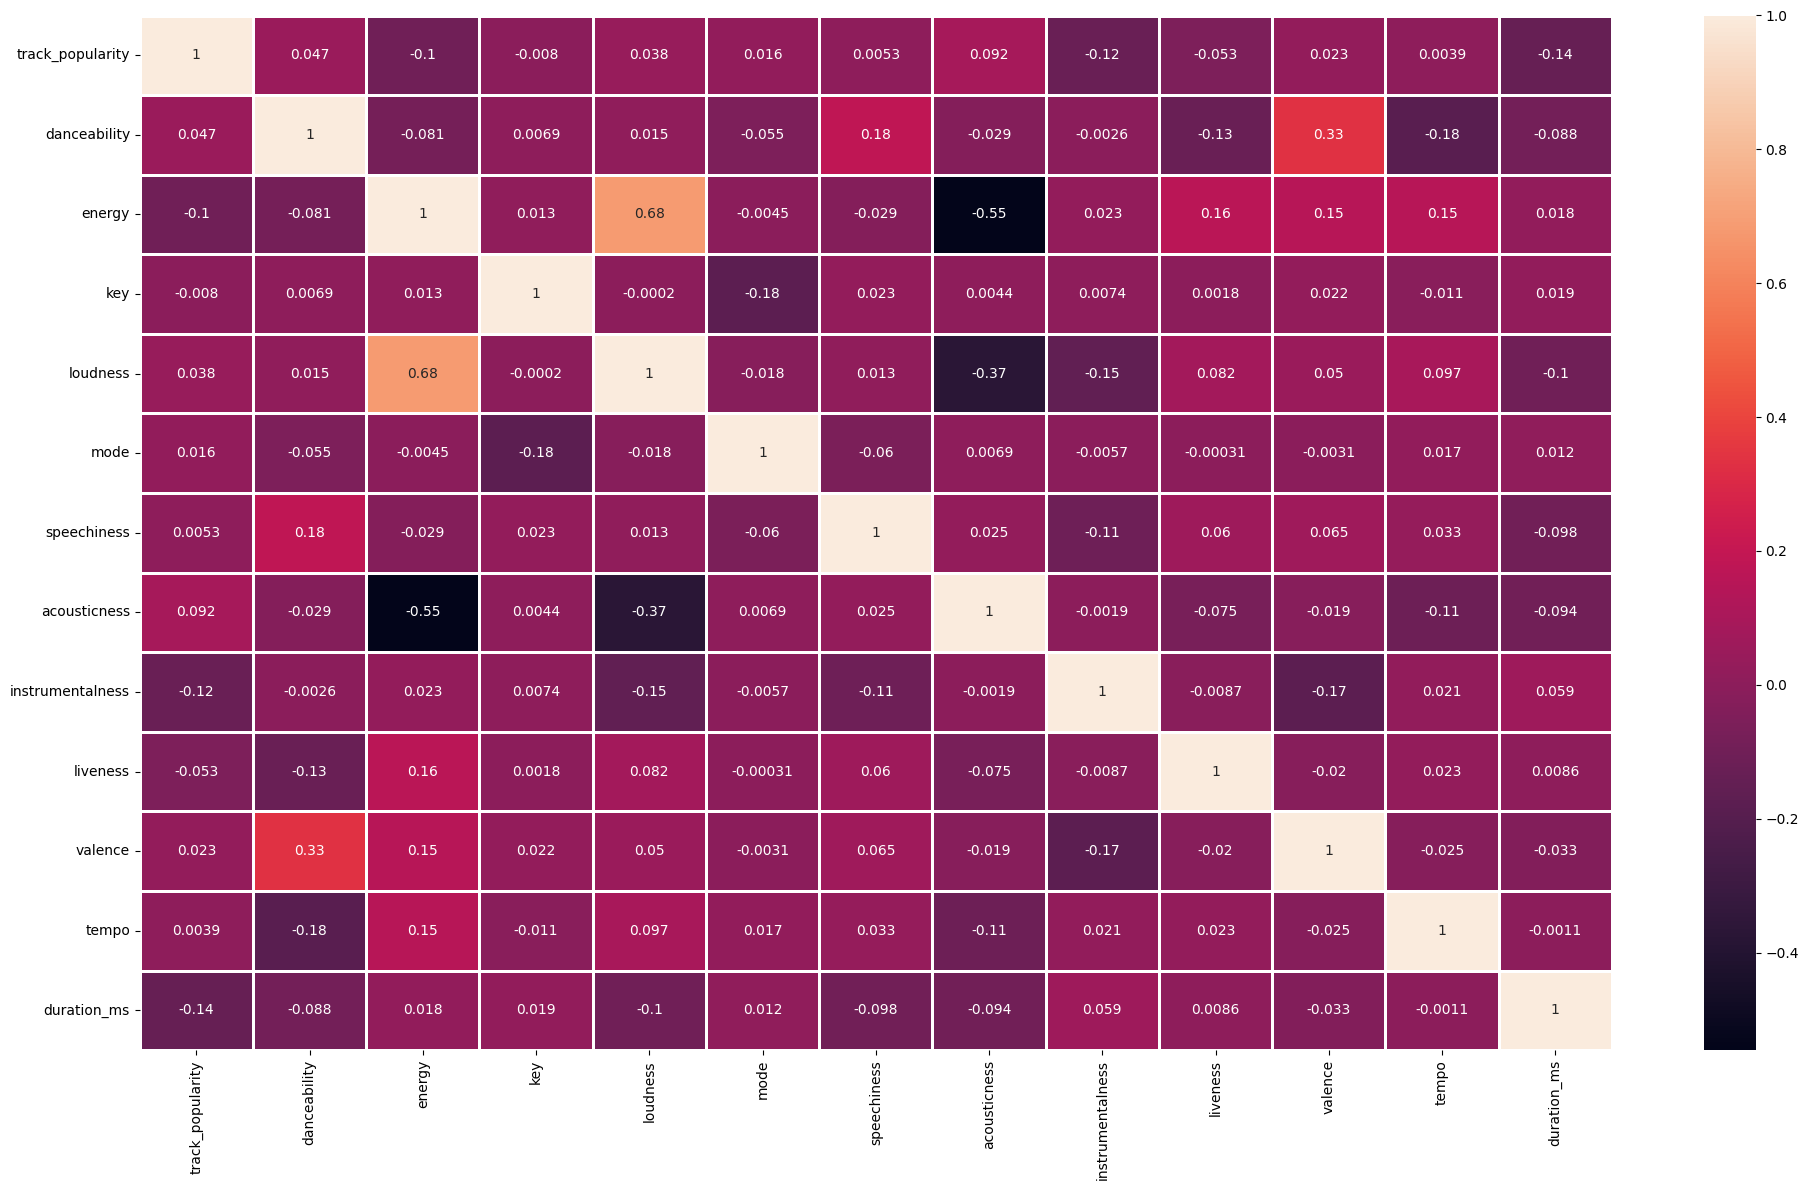

In [10]:
# check the correlation between features

plt.figure(figsize=(20,12))
sns.heatmap(songs_data.corr(),annot=True,linewidth =2)
plt.tight_layout()

# question: which features are highly correlated? 

In [11]:
# can also use this definition, as the plot can be difficult to read sometimes

identify_highly_correlated_features(songs_data, correlation_threshold=0.9)

# drop any features that are highly correlated


""


In [12]:
# check the distribution of the target

songs_data.genre.value_counts(dropna = True, normalize = True)

# The data is slightly imbalanced, with roughly 36% of patients having had a heart disease

rap      0.190590
pop      0.181117
edm      0.171785
r&b      0.158790
rock     0.151852
latin    0.145866
Name: genre, dtype: float64

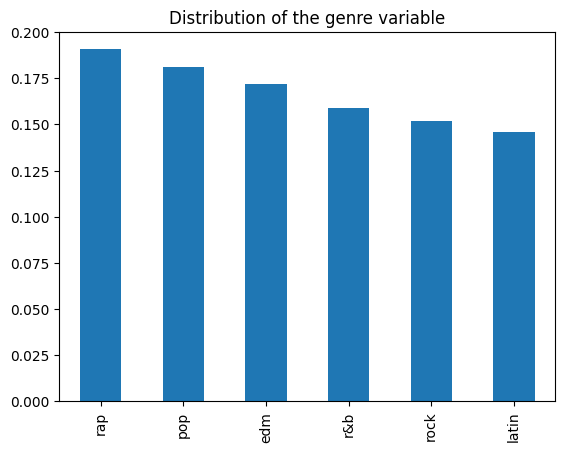

In [13]:
# visualise the distribution of the target

songs_data.genre.value_counts(normalize = True).plot(kind = 'bar')
plt.title("Distribution of the genre variable");

# This is an example of an imbalanced dataset

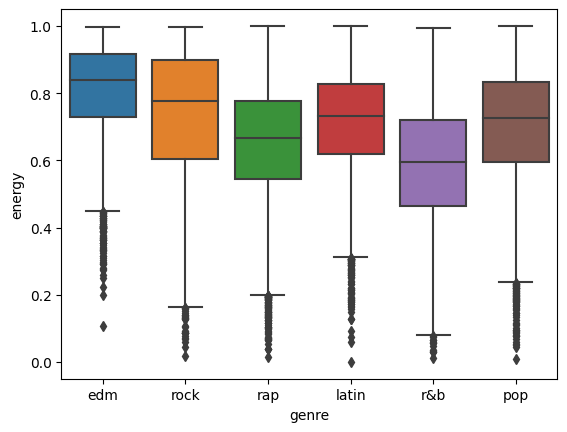

In [14]:
# Bonus - looking at patterns in the data

# I am interested in looking at patterns between energy and the genre.
# My assumption is that older people have had more heart attacks, even though this has a low correlation.

sns.boxplot(x=songs_data.genre, y=songs_data.energy);

# The boxplots show that patients with heart attacks have a higher age range, than patients that have not.
# Younger patients are considered outliers amongst patients with heart attacks. That's interesting!

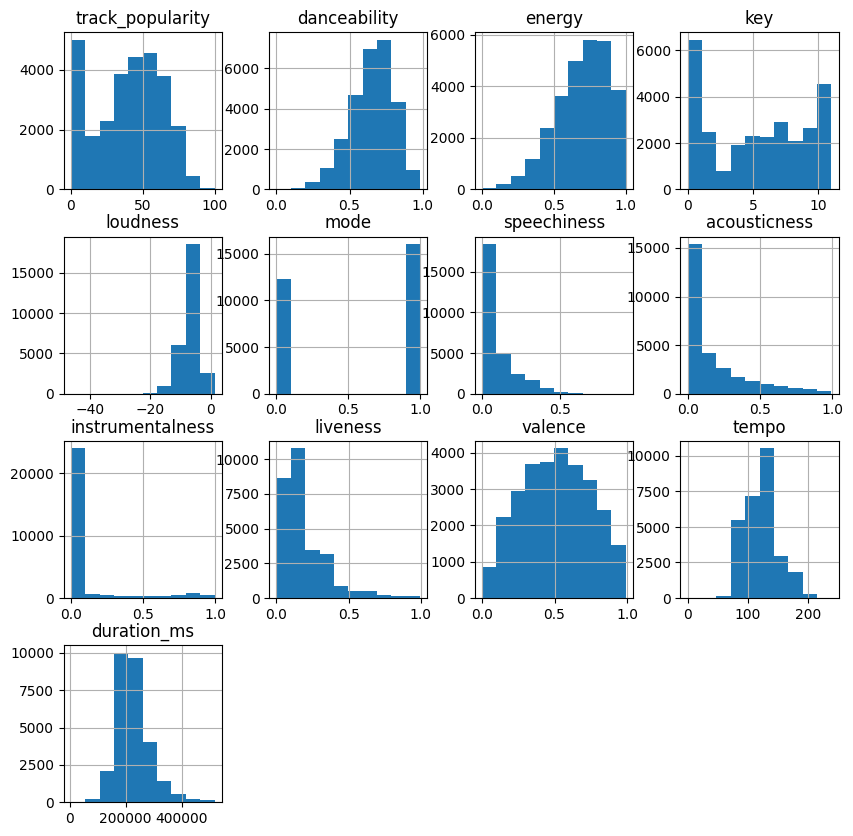

In [15]:
# Bonus visualise the distribution of the variables

songs_data.hist(figsize=(10,10));

# some variables showing signs of normal distriution for e.g. thalach and possibly age, but most variables are skewed

In [16]:
# question: check how much missing data we have

missing_value_df = identify_missing_data(songs_data)
missing_value_df

,feature,percent_missing,data_type
0,track_artist,0.01,object
1,track_name,0.01,object


In [17]:
print("# of features with missing data:", missing_value_df.shape[0])

# of features with missing data: 2


#of features with missing data: 8
The goal of EDA is to understand the data and identify if we need to do any additional data cleaning or feature engineering.

We have already dropped features with low standard deviation, so we do not have drop any additional features
Since we have no highly correlated features (positive or negative), we do not have to drop any features
All the features have a numerical data type, so we do not have to do any additonal encoding
We have 8 features with missing data, so we have to handle this

# Data Cleaning

## Handling Missing Data

In [18]:
# Drop rows with missing data

songs_data = songs_data.dropna(inplace=False)

In [19]:
# Checking drop missing data
songs_data.isnull().sum()

track_id            0
track_name          0
track_artist        0
track_popularity    0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
dtype: int64

## Handling Duplicates

In [20]:
# check if the data has any duplicates

songs_data[songs_data.duplicated(keep=False)]


,track_id,track_name,track_artist,track_popularity,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
1033,2CZFVWvkIatZGqHJ9IcpzE,Parachute,NSTASIA,37,r&b,0.814,0.4810,5,-6.448,0,0.1010,0.53000,0.000006,0.1290,0.573,119.008,188962
1326,4suDPyEfKYtqDR2OGblbTi,9と4分の3番線で君を待つ (Run Away) - Japanese Ver.,TOMORROW X TOGETHER,48,pop,0.630,0.7870,1,-4.302,1,0.1030,0.00489,0.000000,0.1340,0.466,128.997,211867
1483,6GbWNeR3P9MTCmSyPVHgb1,Taste,Rhye,58,pop,0.768,0.4290,1,-9.401,1,0.0955,0.87500,0.419000,0.1150,0.415,104.026,225600
1546,1BINQwBuKPKhpDyXipBXLl,Fly By Night,Rush,0,rock,0.495,0.7790,7,-6.678,1,0.0706,0.04570,0.000200,0.0813,0.545,139.076,201413
1744,5ceEaDSTtQR6HQ9yfEB6Sj,Yamamoto - KMN Street EP,Noah,40,rap,0.781,0.7050,7,-4.821,0,0.0974,0.37700,0.000000,0.1640,0.276,93.973,188936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27122,7DuLZ8HdkbJsFSIBJTYV9U,Grasshopper,Agnes Obel,35,pop,0.734,0.0772,2,-19.600,1,0.0544,0.84600,0.950000,0.0905,0.159,120.070,158360
27380,35rnikz5NAOTvdc4gYzJFN,Sieben,Subway To Sally,41,pop,0.453,0.9860,9,-1.853,0,0.1140,0.00354,0.000000,0.1770,0.284,161.928,206289
27911,2lWfuwRnN6aSk50TPx6eCk,If The World,Guns N' Roses,2,rock,0.645,0.7400,7,-9.414,1,0.0528,0.00542,0.023900,0.1150,0.783,146.434,293507
28132,4lqEFIB9YZl8BwR99L5H3b,In My Room (feat. Ty Dolla $ign & Tyga),Mustard,61,rap,0.745,0.8690,6,-4.375,1,0.0444,0.00193,0.000000,0.0799,0.814,104.015,168641


Checking if droped the duplicates

In [21]:
# going to drop the first appearance of duplicated data

print("shape of data after dropping with the duplicates:", songs_data.shape)

#drop duplicated data
songs_data_cleaned = songs_data[~songs_data.duplicated()]

print("shape of data before dropping one of the duplictaes:", songs_data_cleaned.shape)
# we dropped 40 row of data

shape of data after dropping with the duplicates: (28392, 17)
shape of data before dropping one of the duplictaes: (28352, 17)


In [22]:
# Checking data type of the feature
songs_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28352 entries, 0 to 28395
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          28352 non-null  object 
 1   track_name        28352 non-null  object 
 2   track_artist      28352 non-null  object 
 3   track_popularity  28352 non-null  int64  
 4   genre             28352 non-null  object 
 5   danceability      28352 non-null  float64
 6   energy            28352 non-null  float64
 7   key               28352 non-null  int64  
 8   loudness          28352 non-null  float64
 9   mode              28352 non-null  int64  
 10  speechiness       28352 non-null  float64
 11  acousticness      28352 non-null  float64
 12  instrumentalness  28352 non-null  float64
 13  liveness          28352 non-null  float64
 14  valence           28352 non-null  float64
 15  tempo             28352 non-null  float64
 16  duration_ms       28352 non-null  int64 

In [23]:
#Drop features with object type
songs_data_cleaned=songs_data_cleaned.drop(['track_id','track_name','track_artist'], axis = 1)

The goal of EDA is to understand the data and identify if we need to do any additional data cleaning or feature engineering. From the EDA from last week, and this week, we know:

We have 0 numerical features with missing data left.
All the features have a numerical data type type, so we do not have to do any additonal encoding
Since we have no highly correlated features (positive or negative), we do not have to drop any features
From the EDA last week, we identified one feature with low standard deviation. However, this was also dropped during the data cleaning.

# Feature Engineering

We need to encode the types of genre to numbers

In [24]:
# Checking all genre
songs_data_cleaned.genre.unique()

array(['edm', 'rock', 'rap', 'latin', 'r&b', 'pop'], dtype=object)

In [25]:
# label_encoder object knows 
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

songs_data_cleaned['genre_encode']= label_encoder.fit_transform(songs_data_cleaned['genre'])
  
songs_data_cleaned['genre_encode'].unique()

array([0, 5, 4, 1, 3, 2])

In [26]:
#Checking the encode
songs_data_cleaned

,track_popularity,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genre_encode
0,79,edm,0.760,0.964,2,-5.844,1,0.0576,0.001820,0.700000,0.0974,0.6410,125.000,248036,0
1,3,rock,0.581,0.831,1,-8.045,1,0.1070,0.045800,0.000000,0.0782,0.8850,144.684,168160,5
2,0,edm,0.661,0.760,8,-4.769,1,0.0268,0.000406,0.040700,0.6110,0.4390,99.993,271238,0
3,62,rap,0.718,0.679,11,-5.899,0,0.0706,0.001910,0.010400,0.3850,0.2050,157.970,173347,4
4,15,rock,0.426,0.619,4,-11.501,0,0.0722,0.000084,0.002390,0.1700,0.3820,162.721,168440,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28391,35,rock,0.253,0.931,11,-3.093,1,0.0616,0.000595,0.002170,0.0978,0.3320,194.911,208077,5
28392,2,r&b,0.748,0.629,0,-8.420,1,0.0660,0.016800,0.000000,0.0991,0.9190,182.448,294947,3
28393,58,pop,0.686,0.332,9,-11.759,1,0.0454,0.890000,0.342000,0.1070,0.0745,80.994,237037,2
28394,33,edm,0.845,0.505,10,-5.481,1,0.0516,0.057500,0.000424,0.0335,0.2050,125.037,143095,0


### Exploring the data after feature eng

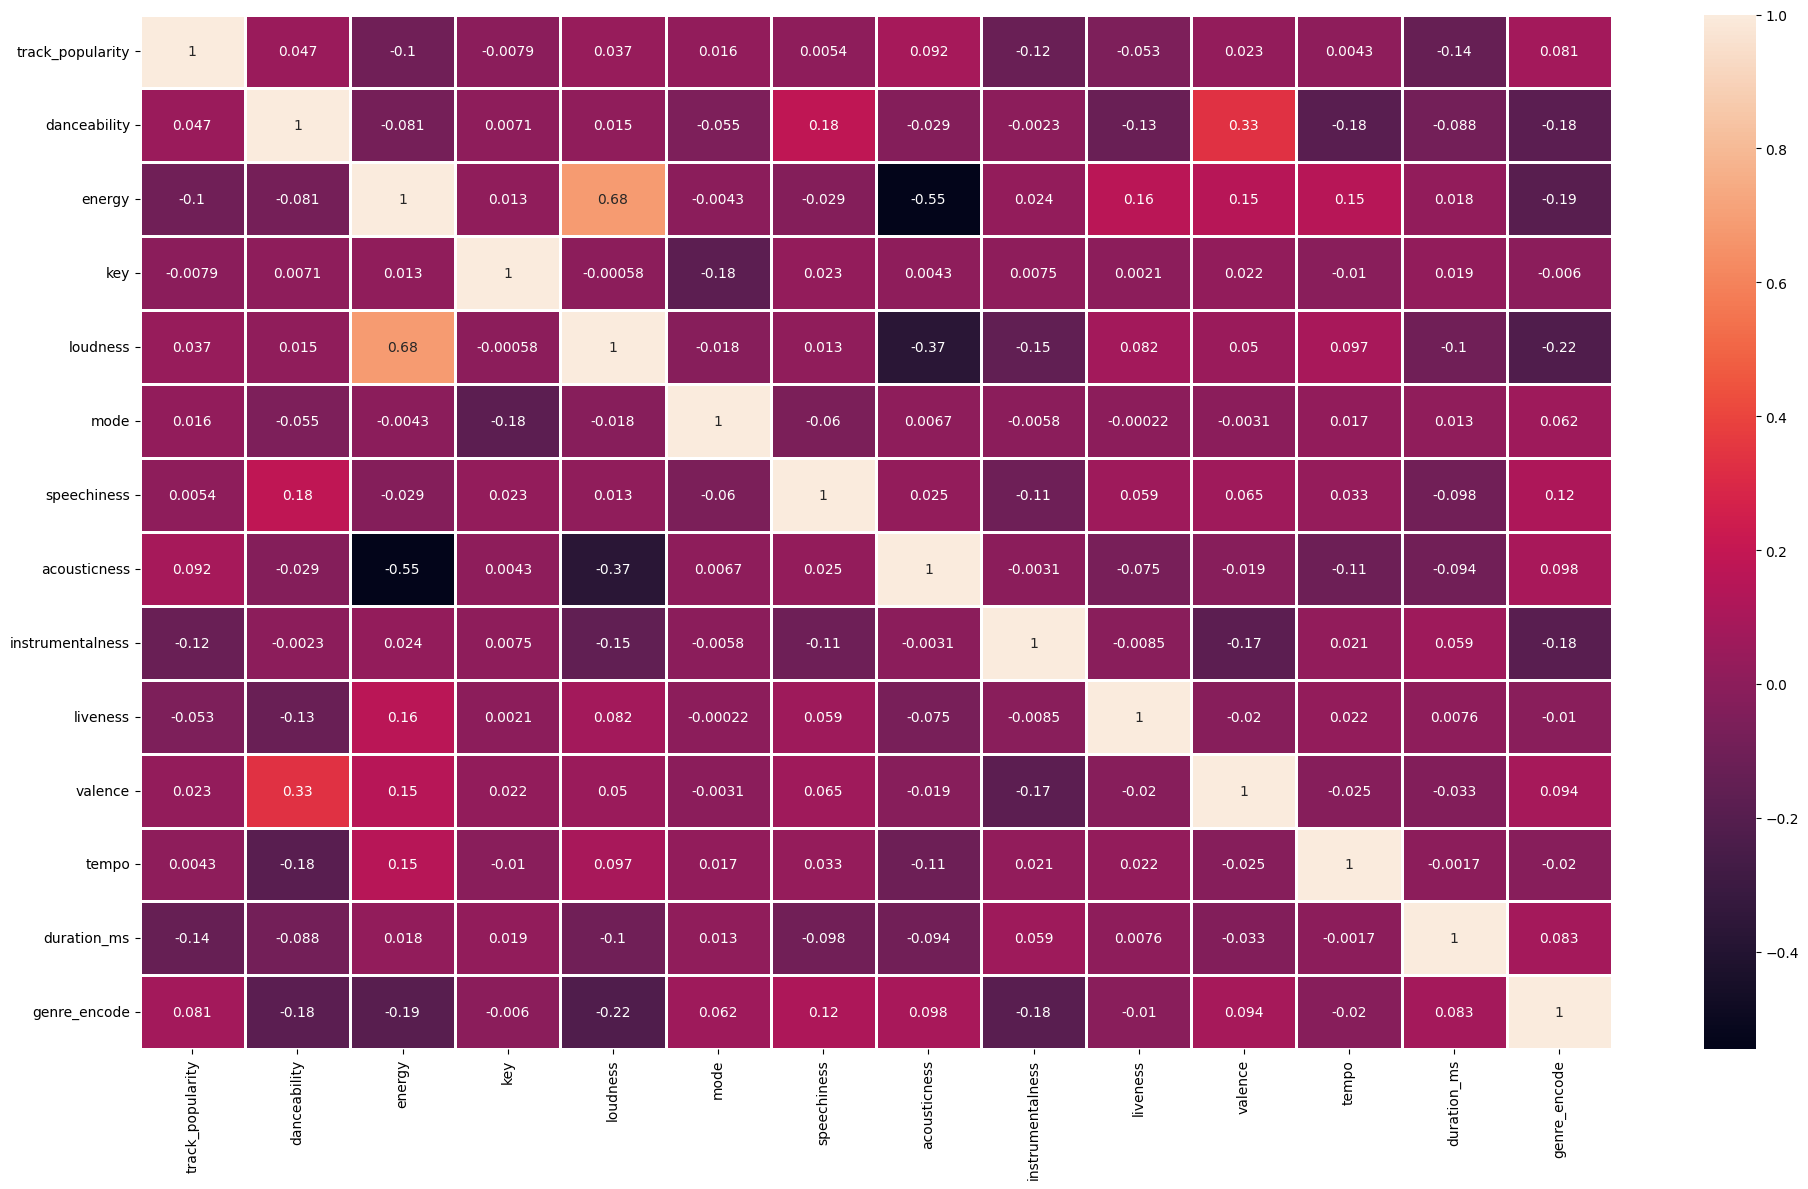

In [27]:
df=songs_data_cleaned
plt.figure(figsize=(20,12))
sns.heatmap(df.corr(numeric_only=True),annot=True, linewidth=2)
plt.tight_layout()

### Selecting the feature for the ML model

In [28]:
df_cleaned = df.copy()


df_cleaned=df_cleaned.drop(['track_popularity','key','mode','liveness'], axis = 1)

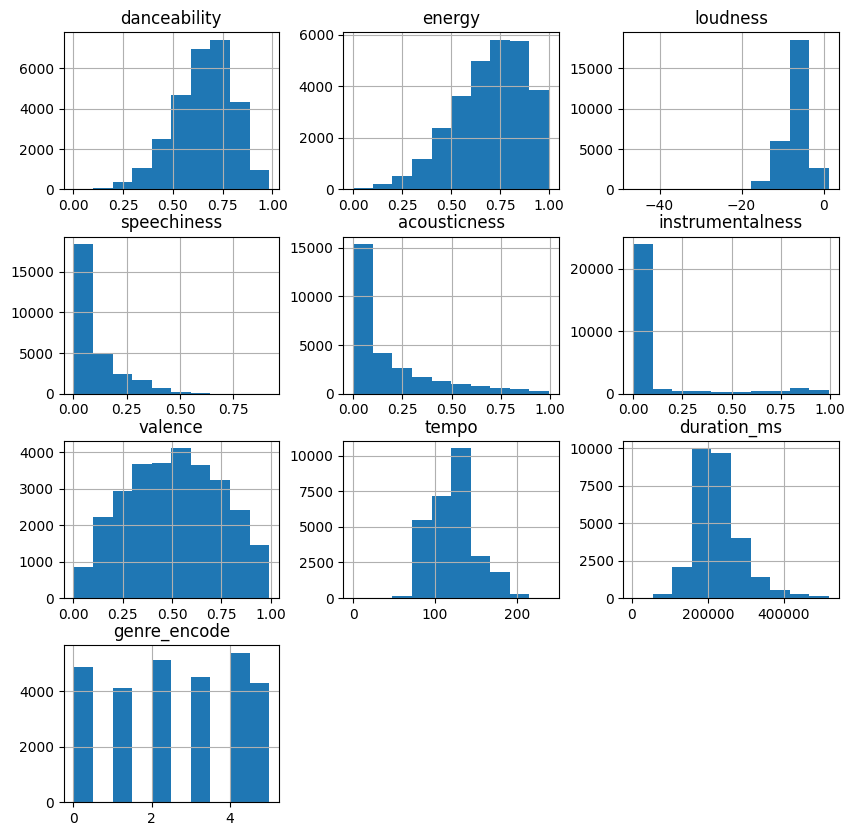

In [29]:
df_cleaned.hist(figsize=(10, 10));

## Building the ML Model

In [30]:
# define our feature and target
target = df_cleaned.genre_encode
features = df_cleaned.drop(['genre','genre_encode'], axis = 1)

#### scaling the features

In [31]:
scaler = MinMaxScaler()
scaler.fit(features)
features_scaled = scaler.transform(features)

features_scaled

array([[0.77314344, 0.9639937 , 0.85082665, ..., 0.64682139, 0.52205145,
        0.47495378],
       [0.59104781, 0.83097042, 0.80470633, ..., 0.89303734, 0.60425994,
        0.31949553],
       [0.67243133, 0.75995799, 0.87335247, ..., 0.44298688, 0.41761193,
        0.52011055],
       ...,
       [0.69786368, 0.33188308, 0.72688222, ..., 0.07517659, 0.33826428,
        0.45354703],
       [0.85961343, 0.50491336, 0.85843304, ..., 0.20686176, 0.52220598,
        0.27071291],
       [0.68769074, 0.58192684, 0.81445006, ..., 0.45105954, 0.51792516,
        0.37098928]])

In [32]:
# the shape of the features data frame and the scaled features are the same
print(features.shape)
print(features_scaled.shape)

(28352, 9)
(28352, 9)


### Looking for outliers

In [33]:
# #q1 and q3
# # if we had no missing values we could use np.percentile

# q1 = np.nanpercentile(df_cleaned.energy, 25)
# q3 = np.nanpercentile(df_cleaned.energy, 75)

# print("25th percentie:", q1)
# print("75th percentie:", q3)

In [34]:
# iqr = q3 - q1
# UB = q3 + 1.5*iqr
# LB = q1 - 1.5*iqr

# print("Values above", UB, "and values below", LB, "are outliers")

In [35]:
# # plot a boxplot for a numerical column

# sns.boxplot(x = df_cleaned.energy, color = 'red');

In [36]:

# # subsetting the data frame where total amount usd is greater than UB and less than LB

# df_cleaned[(df_cleaned.energy > UB) |
#           (df_cleaned.energy < LB)]

In [37]:
# # number of outliers 

# df_cleaned[(df_cleaned.energy > UB) | (df_cleaned.energy < LB)].shape[0]

In [38]:
# lista=['danceability', 'energy', 'loudness','instrumentalness','genre_encode']
# for column in lista:
#     q1 = np.nanpercentile(df_cleaned[column], 25)
#     q3 = np.nanpercentile(df_cleaned[column], 75)
#     print("Column:", column)
#     print("25th percentile:", q1)
#     print("75th percentile:", q3)
#     print()  # Adding an empty line for readability
   

In [39]:
df_cleaned.columns

Index(['genre', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'valence', 'tempo', 'duration_ms',
       'genre_encode'],
      dtype='object')

In [40]:
# for column in lista:
#     q1 = np.nanpercentile(df_cleaned[column], 25)
#     q3 = np.nanpercentile(df_cleaned[column], 75)
    
#     iqr = q3 - q1
#     UB = q3 + 1.5 * iqr
#     LB = q1 - 1.5 * iqr
    
#     print("Column:", column)
#     print("25th percentile:", q1)
#     print("75th percentile:", q3)
#     print("IQR:", iqr)
#     print("Upper Bound (UB):", UB)
#     print("Lower Bound (LB):", LB)
#     print("Values above", UB, "and values below", LB, "are outliers")
#     print()  # Adding an empty line for readability

In [41]:
# for column in lista:
#     q1 = np.nanpercentile(df_cleaned[column], 25)
#     q3 = np.nanpercentile(df_cleaned[column], 75)
    
#     iqr = q3 - q1
#     UB = q3 + 1.5 * iqr
#     LB = q1 - 1.5 * iqr
    
#     print("Column:", column)
#     print("25th percentile:", q1)
#     print("75th percentile:", q3)
#     print("IQR:", iqr)
#     print("Upper Bound (UB):", UB)
#     print("Lower Bound (LB):", LB)
    
#     outliers = df_cleaned[(df_cleaned[column] > UB) | (df_cleaned[column] < LB)]
#     num_outliers = outliers.shape[0]
    
#     print("Values above", UB, "and values below", LB, "are outliers")
#     print("Number of outliers:", num_outliers)
#     print()  # Adding an empty line for readability

In [42]:
# the shape of the features data frame and the scaled features are the same
print(features.shape)
print(features_scaled.shape)

(28352, 9)
(28352, 9)


# Random Forest Model

In [43]:
# split the heart disease data into training and test data

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(features_scaled, 
                                                                  target,
                                                                  test_size = 0.2, 
                                                                  random_state = 8888)

In [44]:
# model = Ridge(alpha=0.5)

In [45]:
# model.fit(X_train_scaled, y_train)

In [46]:
# y_pred = model.predict(X_test_scaled)

In [47]:
# mse = mean_squared_error(y_test, y_pred)
# print("Erro quadrático médio:", mse)

In [48]:
# print the shape of the training data

print("Training Data")
print("Shape of X_train", X_train_scaled.shape)
print("Shape of y_train", y_train.shape)

Training Data
Shape of X_train (22681, 9)
Shape of y_train (22681,)


In [49]:
# print the shape of the test data 

print("Test Data")
print("Shape of X_test", X_test_scaled.shape)
print("Shape of y_test", y_test.shape)

Test Data
Shape of X_test (5671, 9)
Shape of y_test (5671,)


In [50]:
# Import and Fit the Random Forest Model

clf_rf = RandomForestClassifier()

clf_rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [51]:
# Make predictions on unseen data

y_pred_rf = clf_rf.predict(X_test_scaled) 
y_pred_rf

array([5, 1, 3, ..., 4, 2, 1])

In [52]:
print("first five predicted values:", y_pred_rf[0:5])
print("first five actual values:", list(y_test[0:5]))

first five predicted values: [5 1 3 4 5]
first five actual values: [5, 3, 3, 4, 5]


In [53]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print("accuracy:", round(accuracy_score(y_test, y_pred_rf), 2))
print("recall:", round(recall_score(y_test, y_pred_rf, average='macro'), 2))
print("precision:", round(precision_score(y_test, y_pred_rf, average='macro'), 2))
print("f1-score:", round(f1_score(y_test, y_pred_rf, average='macro'), 2))


accuracy: 0.57
recall: 0.57
precision: 0.56
f1-score: 0.56


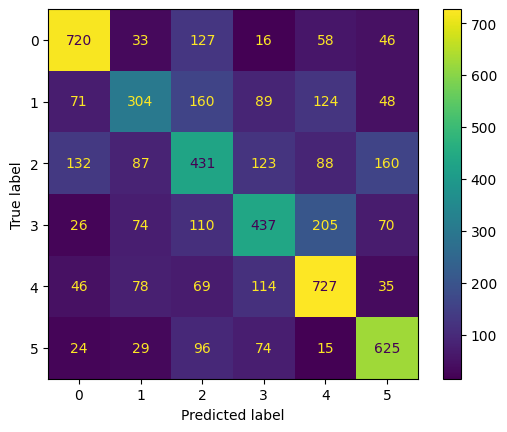

In [54]:
# plot confusion matrix

cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf_rf.classes_)

disp.plot()
plt.show()

In [55]:
# print classification report

print(classification_report(y_test, y_pred_rf))

# slight improvement, drop in misclassifying patients without heart disease

              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1000
           1       0.50      0.38      0.43       796
           2       0.43      0.42      0.43      1021
           3       0.51      0.47      0.49       922
           4       0.60      0.68      0.64      1069
           5       0.64      0.72      0.68       863

    accuracy                           0.57      5671
   macro avg       0.56      0.57      0.56      5671
weighted avg       0.57      0.57      0.57      5671



In [ ]:
# Plot the learning curve

learning_curve_plot(clf_rf, X_train_scaled, y_train, scoring = 'accuracy')

In [ ]:
# feature importance plot

feature_importance_plot(clf_rf, X_train_scaled, n = 5) 

# unlike decision tree, where slope was the dominant feature , 
# seeing signs of more features being used to split the nodes

# XGBoost Model

In [ ]:
# Import the required libraries
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Create an instance of the XGBoost classifier
clf_xgb = XGBClassifier()

# Fit the classifier on the training data
clf_xgb.fit(X_train_scaled, y_train)

# Make predictions on unseen data
y_pred_xgb = clf_xgb.predict(X_test_scaled)

# Print the predicted values and actual values for the first five samples
print("First five predicted values:", y_pred_xgb[:5])
print("First five actual values:", list(y_test[:5]))

# Evaluate the performance of the model
print("Accuracy:", round(accuracy_score(y_test, y_pred_xgb), 2))
print("Recall:", round(recall_score(y_test, y_pred_xgb, average='macro'), 2))
print("Precision:", round(precision_score(y_test, y_pred_xgb, average='macro'), 2))
print("F1-Score:", round(f1_score(y_test, y_pred_xgb, average='macro'), 2))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_xgb.classes_)
disp.plot()
plt.show()

# Print the classification report
print(classification_report(y_test, y_pred_xgb))
